In [2]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import os
import math
import time
from pyentrp import entropy as entpy
from math import factorial, log
from scipy.signal import periodogram, welch
from IPython.display import Audio
from sklearn.decomposition import NMF
from itertools import combinations
from ast import literal_eval
from librosa import feature as libft

def hamming_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.53836 - 0.46164*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])

def hann_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.5 - 0.5*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])

def get_spectrogram(audio, samplerate, N=512, padding=512, overlap=0, window='tukey', whole=False):
    # Lista donde se almacenará los valores del espectrograma
    spect = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(N)
    elif window == 'hamming':
        wind_mask = hamming_window(N)
    elif window == 'hann':
        wind_mask = hann_window(N)
    elif window == 'nuttall':
        wind_mask = nuttall(N)
    elif window is None:
        wind_mask = np.array([1] * N)
    
    # Iteración sobre el audio
    while audio.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(audio) >= N:
            q_samples = N
            step = int(N * (1 - overlap))
        else:
            break
            # q_samples = step = len(audio)
            
        # Recorte en la cantidad de muestras
        audio_frame = audio[:q_samples]
        audio = audio[step:]
               
        # Ventaneando
        audio_frame_wind = audio_frame * wind_mask
        
        # Aplicando padding
        audio_padded = np.append(audio_frame_wind, [0] * padding)
        
        # Aplicando transformada de fourier
        audio_fft = np.fft.fft(audio_padded)
               
        # Agregando a los vectores del espectro
        spect.append(audio_fft)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a que está reflejado
    # hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N+padding)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex64)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, (N+padding)//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex64)[:, :(N+padding)//2 + 1]
    
    # Se retornan los valores que permiten construir el espectrograma correspondiente
    return times, freqs, spect.T

def get_inverse_spectrogram(X, overlap=0, window='tukey', whole=False):
    # Preguntar si es que la señal está en el rango 0-samplerate. En caso de que no sea así,
    # se debe concatenar el conjugado de la señal para recuperar el espectro. Esto se hace así
    # debido a la propiedad de las señales reales que dice que la FT de una señal real entrega
    # una señal hermitiana (parte real par, parte imaginaria impar). Luego, como solo tenemos
    # la mitad de la señal, la otra parte correspondiente a la señal debiera ser la misma pero
    # conjugada, para que al transformar esta señal hermitiana mediante la IFT, se recupere una
    # señal real (correspondiente a la señal de audio).
    if not whole:
        # Se refleja lo existente utilizando el conjugado
        X = np.concatenate((X, np.flip(np.conj(X[1:-1, :]), axis=0)))
        
    # Obtener la dimensión de la matriz
    rows, cols = X.shape
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(rows)
    elif window == 'hamming':
        wind_mask = hamming_window(rows)
    elif window == 'hann':
        wind_mask = hann_window(rows)
    elif window == 'nuttall':
        wind_mask = nuttall(rows)
    elif window is None:
        wind_mask = np.array([1] * rows)
        
    # A partir del overlap, el tamaño de cada ventana de la fft (dimensión fila) y la cantidad de
    # frames a las que se les aplicó la transformación (dimensión columna), se define la cantidad
    # de muestras que representa la señal original
    step = int(rows * (1 - overlap))      # Tamaño del paso
    total_samples = step * cols + rows    # Tamaño total del arreglo
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_spect = np.zeros((total_samples,), dtype=np.complex128)
    # Definición de una lista de suma de ventanas cuadráticas en el tiempo
    sum_wind2 = np.zeros((total_samples,), dtype=np.complex128)
    
    # Transformando columna a columna (nótese la división en tiempo por una ventana definida)
    for i in range(cols):
        beg = i * step
        # Se multiplica por el kernel para la reconstrucción a partir de la ventana aplicada inicialmente
        # Fuente: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html
        inv_spect[beg:beg+rows] += np.fft.ifft(X[:, i]) * wind_mask
        
        # Se suma la ventana al cuadrado (que sirve como ponderador temporal)
        sum_wind2[beg:beg+rows] += wind_mask ** 2
    
    # Finalmente se aplica la normalización por la cantidad de veces que se suma cada muestra
    # en el proceso anterior producto del traslape, utilizando las ventanas correspondientes
    return np.real(np.divide(inv_spect, sum_wind2 + 1e-15))

def wiener_filter(V, WiHi, W, H, alpha=1):
    # El filtro de Wiener permite generar una máscara que obtenga información
    # del espectrograma original a partir de la proporción obtenida mediante la
    # multiplicación de las matrices W y H (estimación de la señal original)
    
    # Obteniendo la máscara
    mask = np.divide(WiHi ** alpha, np.matmul(W, H) + 1e-15)
    
    # Aplicando la máscara al espectrograma original, se obtiene el resultado
    # final del proceso de separación de fuentes
    return mask * V

def nmf_to_spectrogram(audio, samplerate, N=4096, overlap=0.75, padding=0, 
                       window='hamming', wiener_filt=True, alpha_wie=1,
                       n_components=2, init='random', solver='mu', beta=2,
                       tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                       random_state=100, W_0=None, H_0=None, whole=False):
    '''Función que a partir del archivo de audio (ingresado en la variable 
    "audio") transforma los datos en un espectrograma con traslape dado por 
    la variable "overlap" (0 para no tener traslape y 0.99 para 99% de 
    traslape) y una cantidad de "padding" puntos.

    Esta transformación además usa ventanas definidas por la variable "window", 
    que puede variar entre "tukey", "hamming", "hann", "nuttall" y sin ventana 
    (None).
    
    Además utiliza todos los parámetros relevantes para este estudio del comando
    NMF programado en la librería sklearn, disponible en:
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
    
    Finalmente, presenta la opción de aplicar un filtro de Wiener al resultado 
    de las matrices obtenidas mediante NMF, utilizando la variable booleana 
    "wiener_filt", y calibrando el valor de alpha propio de la máscara mediante 
    la variable "alpha_wie".'''
    
    # Propiedad del overlap
    overlap = 0.99 if overlap >= 0.99 else overlap
    
    # Definición de una lista que almacene las componentes
    components = []
    # Listas de valores de interés
    Y_list = []
    
    # Obteniendo el espectrograma
    t, f, S = get_spectrogram(audio, samplerate, N=N, padding=padding, 
                              overlap=overlap, window=window, whole=whole)
    
    # Definiendo la magnitud del espectrograma (elemento a estimar)
    X = np.abs(S)
    
    # Definiendo el modelo de NMF
    model = NMF(n_components=n_components, init=init, solver=solver,
                beta_loss=beta, tol=tol, max_iter=max_iter, 
                random_state=random_state, alpha=alpha_nmf, l1_ratio=l1_ratio)
    
    # Ajustando
    if init == 'random':
        W = model.fit_transform(X)
    else:
        W = model.fit_transform(X, W=W_0, H=H_0)
        
    H = model.components_
    
    # Se define la función de transformación para Yi
    if wiener_filt:
        # Se aplica filtro de Wiener
        filt = lambda source_i: wiener_filter(X, source_i, W, H, 
                                              alpha=alpha_wie)
    else:
        # Solo se entrega la multiplicación W_i * H_i
        filt = lambda source_i: source_i
    
    # Obteniendo las fuentes
    for i in range(n_components):
        source_i = np.outer(W[:,i], H[i])
        
        # Aplicando el filtro
        Yi = filt(source_i) * np.exp(1j * np.angle(S))
        
        # Y posteriormente la transformada inversa
        yi = get_inverse_spectrogram(Yi, overlap=overlap, window=window, 
                                     whole=whole)
        
        # Agregando a la lista de componentes
        components.append(np.real(yi))
        Y_list.append(Yi)
        
    return np.array(components), t, f, X, np.array(Y_list), W, H

## Definición de entropía espectral por unidad de energía

In [10]:
def spectral_entropy(signal, samplerate, method='fft', 
                     nperseg_welch=None, normalize=False,
                     epsilon=1e-10):
    """Basado en la función implementada en la librería EntroPy:
    https://raphaelvallat.com/entropy/build/html/index.html"""
    # Transformación de la señal en un arreglo
    signal = np.array(signal)
    
    # Obtener el espectro a trabajar
    if method == 'fft':
        _, psd = periodogram(signal, samplerate)
    elif method == 'welch':
        _, psd = welch(signal, samplerate, nperseg=nperseg_welch)
    
    # Se obtiene el psd normalizado
    psd_norm = np.divide(psd, psd.sum())
    
    # Y se calcula la entropía espectral
    spect_ent = -np.multiply(psd_norm, np.log2(psd_norm + epsilon)).sum()
    
    # Normalizando por el log2
    if normalize:
        spect_ent /= np.log2(psd_norm.size)
        
    return spect_ent


def spectral_entropy_enorm(signal, samplerate, method='fft', 
                           nperseg_welch=None, normalize=False,
                           epsilon=1e-10):
    """Variación de la definición de la entropía espectral, normalizando
    por la energía de la señal."""
    # Energía total de la señal
    total_energy = sum(abs(np.array(signal)) ** 2)
    
    return spectral_entropy(signal, samplerate, method='fft', 
                            nperseg_welch=None, normalize=False,
                            epsilon=1e-10) / total_energy

## Definición de entropía aproximada

In [11]:
def approximate_entropy(signal, m, r):
    """Expresión de la entropía aproximada basada en lo descrito en el texto
    [2015] - Stephan Schwill. Entropy Analysis of Financial Time. Capítulo 2.4.
    Referencia base código: https://en.wikipedia.org/wiki/Approximate_entropy
    
    Parámetros:
    - m: Cantidad de muestras a utilizar por sub bloque
    - r: Parámetro de separación máxima (threshold)
    """
    
    # Definición de la dimensión de la señal
    N = len(signal)
    
    def _maxdist(x_i, x_j):
        return max(abs(np.array(x_i) - np.array(x_j)))
    
    def _phi(m):
        # Generación de las listas de los grupos x_i 
        x = [np.array([signal[j] for j in range(i, i + m - 1 + 1)]) for i in range(N - m + 1)]
        
        # Calculando los valores de c_i para cada x_i
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1) for x_i in x]
        return sum(np.log(C)) / (N - m + 1)
    
    return abs(_phi(m+1) - _phi(m))

## Definición de spectral flatness

In [12]:
def spectral_flatness(signal, N=2024):
    pass

## Definición de una función para calcular la entropía de las componentes, guardarlas y ordenarlas

In [4]:
def get_entropy_nmf_comps(n_comps, filename, samplerate, typentr='spectral', 
                          combinatorial=False, q_comb=None, order=None, 
                          delay=None, record=False, rec_qty=10, savetxt=False):    
    # Se cargan los datos de las componentes
    comp_data = np.load(f'{filename}_Separation_{n_comps}.npz')
    comps = comp_data['comps']
    
    # Marca de tiempo de inicio
    time_beg = time.time()
    
    # Definición de la función de entropía
    if typentr == 'spectral':
        entr_func = lambda signal: spectral_entropy(signal, 
                                                    samplerate, 
                                                    normalize=True)
    elif typentr == 'spectral_norm':
        entr_func = lambda signal: spectral_entropy_enorm(signal, 
                                                          samplerate, 
                                                          normalize=True)
    elif typentr == 'permutation':
        entr_func = lambda signal: entpy.permutation_entropy(signal,
                                                             order=order, 
                                                             delay=delay, 
                                                             normalize=True)
        # Se redefine el nombre
        typentr = f'{typentr}_{order}_{delay}'
    elif typentr == 'apen':
        entr_func = lambda signal: approximate_entropy(signal, 2, 3)
    
    # Definición de la lista de entropías para ordenar
    se_list = list()
    
    # Creación de lista iterable
    if combinatorial:
        # Se definen las posibles combinaciones
        comb_list = combinations(range(n_comps), q_comb)

        for i in comb_list:
            # Se hace una mezcla normalizada de las componentes
            comb_i = np.sum(np.array([comps[c] for c in i]), axis=0) / len(i)

            # Cálculo de la entropía espectral de cada componente
            se = entr_func(comb_i)

            # Se agrega a una lista de entropías, donde el primer elemento
            # es la entropía calculada de la combinación; y el segundo
            # elemento corresponde a los índices de esa combinación
            se_list.append((se, i))

    else:
        comb_list = range(n_comps)

        for i in comb_list:
            # Cálculo de la entropía espectral de cada componente
            se = entr_func(comps[i])

            # Se agrega a una lista de entropías, donde el primer elemento
            # es la entropía calculada de la combinación; y el segundo
            # elemento corresponde a los índices de esa combinación
            se_list.append((se, i))
        
    # Una vez obtenidos todas las entropías componentes con sus 
    # respectivos componentes, se ordena en función de la entropía
    se_list.sort(key=lambda x: x[0])
    
    # Marca de tiempo de término
    time_end = time.time()
    
    # Cálculo de duración de tiempo
    duration = time_end - time_beg
    
    # Opción de grabar audios de componentes
    if record:
        # Creación de la carpeta de componentes
        folder_data = f'{filename}_{n_comps}'
        
        # Preguntar si es que la carpeta que almacenará los sonidos se ha
        # creado. En caso de que no exista, se crea una carpeta
        if not os.path.isdir(folder_data):
            os.mkdir(folder_data)
        
        # Guardando
        for i, comp in enumerate(ind[:rec_qty]):
            sf.write(f'{folder_data}/[{typentr}] {i + 1} - Comp_{comp}.wav', 
                     comps[i], samplerate)
    
    # Guardar combinaciones con entropías en un archivo txt
    if savetxt:
        # Creación de la carpeta de componentes
        folder_data = f'{filename}_{n_comps}'
        
        # Preguntar si es que la carpeta que almacenará los sonidos se ha
        # creado. En caso de que no exista, se crea una carpeta
        if not os.path.isdir(folder_data):
            os.mkdir(folder_data)
        
        # Guardando
        if combinatorial:
            fileout = f'{folder_data}/[{typentr}] Comps_{n_comps} - '\
                      f'Combinatorial_{q_comb}.txt'
        else:
            fileout = f'{folder_data}/[{typentr}] Comps_{n_comps}.txt'
        
        with open(fileout, 'w', encoding='utf8') as file:
            for i in se_list:
                file.write(f'{i}\n')
            file.write(f'\nDuration: {duration} Seconds.')

In [33]:
def get_sound_comps_bytxt(n_comps, filename, lines_to_read, 
                          samplerate, typentr='spectral',
                          combinatorial=False, q_comb=None,
                          order=None, delay=None):
    # Creación de la carpeta de componentes
    folder_data = f'{filename}_{n_comps}'

    # Se cargan los datos de las componentes
    comp_data = np.load(f'{filename}_Separation_{n_comps}.npz')
    comps = comp_data['comps']
    
    # Redefinición de nombre para permutación
    if typentr == 'permutation':
        typentr = f'{typentr}_{order}_{delay}'
    
    # Definición del archivo a revisar y carpeta a crear
    if combinatorial:
        foldlook = f'{folder_data}/[{typentr}] Comps_{n_comps} - Combinatorial_{q_comb}'
    else:
        foldlook = f'{folder_data}/[{typentr}] Comps_{n_comps}'
        lines_to_read = range(n_comps)
        
    # Preguntar si es que la carpeta que almacenará los sonidos se ha
    # creado. En caso de que no exista, se crea una carpeta
    if not os.path.isdir(foldlook):
        os.makedirs(foldlook)
    
    with open(f'{foldlook}.txt', 'r', encoding='utf8') as file:
        # Se obtiene todo el documento
        lines = file.readlines()

        # Leyendo las líneas de interés
        for i in lines_to_read:
            # Se obtiene la línea de interés
            line_i = literal_eval(lines[i].strip())
            
            if combinatorial:
                # Se usan las componentes para obtener la señal
                signal_out = np.sum(np.array([comps[i] for i in line_i[1]]), axis=0)
            else:
                # Se preguntan las componentes en orden
                signal_out = comps[line_i[1]]

            # Se define el nombre de la señal con el siguiente código:
            # [Posición en la lista de entropías] - Comps_...
            # [Componentes que lo constituyen separados por guion]
            filename_out = f'{i} - Comps_{str(line_i[1])}'

            # Guardando el archivo de sonido
            sf.write(f'{foldlook}/{filename_out}.wav', signal_out, samplerate)

In [4]:
def combination_quantity(n, k):
    return math.factorial(n)/(math.factorial(k) * math.factorial(n-k))

n = 20    # Cantidad de componentes a partir de NMF
k = 10     # Cantidad de componentes a combinar a partir de las n originales

print(int(combination_quantity(n, k)))

184756


# Incorporando archivo de audio

In [8]:
filename = 'Drums_zanark'
audio, samplerate = sf.read(f'{filename}.wav')
Audio(audio, rate=samplerate)

# Obteniendo las componentes mediante NMF

In [9]:
n_comp = 20

comps, t, f, X, Y_list, W, H = \
        nmf_to_spectrogram(audio, samplerate, N=4096, overlap=0.75, padding=0, 
                           window='hamming', wiener_filt=True, alpha_wie=1,
                           n_components=n_comp, init='random', solver='mu', beta=2,
                           tol=1e-4, max_iter=200, alpha_nmf=0, l1_ratio=0,
                           random_state=100, W_0=None, H_0=None, whole=False)

# Se guardan los datos del proceso de separación mediante NMF
np.savez(f'{filename}_Separation_{n_comp}.npz', comps=comps)

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\nmf.py:1069: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


# Cálculo de entropías para componentes y sus combinaciones, y registro en archivo txt

In [32]:
# Parámetros
n_comps = 20
q_comb = range(12, 16)
order = 10
delay = 2
typentr = 'spectral_norm'
combinatorial = True

In [33]:
os.path.exists('Drums_zanark_20/[spectral] Comps_20 - Combinatorial_5.txt')

True

In [34]:
print(f'{filename}_{n_comps}/[{typentr}] Comps_{n_comps} - {combtxt}_{5}.txt')
print(os.path.exists(f'{filename}_{n_comps}/[{typentr}] Comps_{n_comps} - {combtxt}_{5}.txt'))

Drums_zanark_20/[spectral_norm] Comps_20 - Combinatorial_5.txt
True


In [35]:
for q in q_comb:
    print(f'Running combination {q} of {n_comps}...')
    # Preguntar en primera instancia si es que el archivo se había creado
    if combinatorial:
        combtxt = 'Combinatorial'
    else:
        combtxt = ''
    
    # Nombre del archivo
    file = f'{filename}_{n_comps}/[{typentr}] Comps_{n_comps} - {combtxt}_{q}.txt'
    print(file)
        
    # Preguntar si es que el archivo existe antes de correrlo
    if not os.path.exists(file):
        print('Getting components...')
        get_entropy_nmf_comps(n_comps, filename, samplerate, savetxt=True,
                              combinatorial=combinatorial, q_comb=q, order=order,
                              delay=delay, typentr=typentr)
    
    print(f'Running combination {q} completed!\n')

Running combination 12 of 20...
Drums_zanark_20/[spectral_norm] Comps_20 - Combinatorial_12.txt
Running combination 12 completed!

Running combination 13 of 20...
Drums_zanark_20/[spectral_norm] Comps_20 - Combinatorial_13.txt
Running combination 13 completed!

Running combination 14 of 20...
Drums_zanark_20/[spectral_norm] Comps_20 - Combinatorial_14.txt
Getting components...
Running combination 14 completed!

Running combination 15 of 20...
Drums_zanark_20/[spectral_norm] Comps_20 - Combinatorial_15.txt
Running combination 15 completed!



# Creación de sonidos para componentes ordenados según su entropía

In [68]:
# Parámetros
n_comps = 20
q_comb = 3
order = 5
delay = 2
typentr = 'spectral'
combinatorial = True

In [69]:
# A modificar
if q_comb == 5 or q_comb == 15:
    lines_to_watch = ([i for i in range(10)], [i for i in range(5000,5010)], [i for i in range(15480, 15490)])
elif q_comb == 10:
    lines_to_watch = ([i for i in range(10)], [i for i in range(90460,90470)], [i for i in range(184730, 184740)])
elif q_comb == 3:
    lines_to_watch = ([i for i in range(10)], [i for i in range(500, 510)], [i for i in range(1120, 1130)])

# Obteniendo los componentes
lines_plain = [elem for i in lines_to_watch for elem in i]
get_sound_comps_bytxt(n_comps, filename, lines_plain, samplerate, combinatorial=combinatorial, 
                      typentr=typentr, q_comb=q_comb, order=order,
                      delay=delay)

# Visualización de tiempos de cálculo por señal

### Entropía espectral

In [19]:
t0 = time.time()
se = spectral_entropy(audio, samplerate, method='fft', normalize=True)
t_end = time.time()

t_se = t_end - t0    # Tiempo de entropía espectral
print(f'Tiempo entropía espectral = {t_se} segs')
print(f'Valor entropía            = {se}')

Tiempo entropía espectral = 0.020943641662597656 segs
Valor entropía            = 0.5823506300926719


### Entropía espectral normalizada

In [26]:
t0 = time.time()
se_norm = spectral_entropy_enorm(audio, samplerate, method='fft', normalize=True)
t_end = time.time()

t_senorm = t_end - t0    # Tiempo de entropía espectral normalizada
print(f'Tiempo entropía espectral = {t_senorm} segs')
print(f'Valor entropía            = {se_norm}')

Tiempo entropía espectral = 0.05379605293273926 segs
Valor entropía            = 0.0017240608067134768


### Entropía de permutación

In [29]:
t0 = time.time()
ent_perm = entpy.permutation_entropy(audio, order=1024, delay=128, normalize=False)
t_end = time.time()

t_perm = t_end - t0    # Tiempo de entropía de permutación
print(f'Tiempo entropía espectral = {t_perm} segs')
print(f'Valor entropía            = {ent_perm}')

Tiempo entropía espectral = 3.2324328422546387 segs
Valor entropía            = 15.09896719622737


### Entropía de Shannon

In [30]:
t0 = time.time()
ent_shan = entpy.shannon_entropy(audio)
t_end = time.time()

t_shan = t_end - t0    # Tiempo de entropía de permutación
print(f'Tiempo entropía espectral = {t_shan} segs')
print(f'Valor entropía            = {ent_shan}')

Tiempo entropía espectral = 1174.8510677814484 segs
Valor entropía            = 17.482083539267514


In [ ]:
print(math.factorial(20))

### Approximate entropy

In [ ]:
t0 = time.time()
apen = approximate_entropy(audio, m=10000, r=2)
t_end = time.time()

t_apen = t_end - t0    # Tiempo de entropía app
print(f'Tiempo ApEn    = {t_apen} segs')
print(f'Valor entropía = {apen}')

### Sample entropy

In [9]:
t0 = time.time()
sa_ent = entpy.sample_entropy(audio, sample_length=1024, tolerance=None)
t_end = time.time()

t_apen = t_end - t0    # Tiempo de entropía app
print(f'Tiempo Sample Entropy    = {t_apen} segs')
print(f'Valor entropía           = {sa_ent}')

Tiempo Sample Entropy    = 1066.335854768753 segs
Valor entropía           = [2.51813728e+00 4.05371679e-01 3.81757859e-01 ... 1.83331501e-04
 1.83365117e-04 1.83398746e-04]


In [10]:
sum(sa_ent)

12.725656769966742

<IPython.core.display.Javascript object>


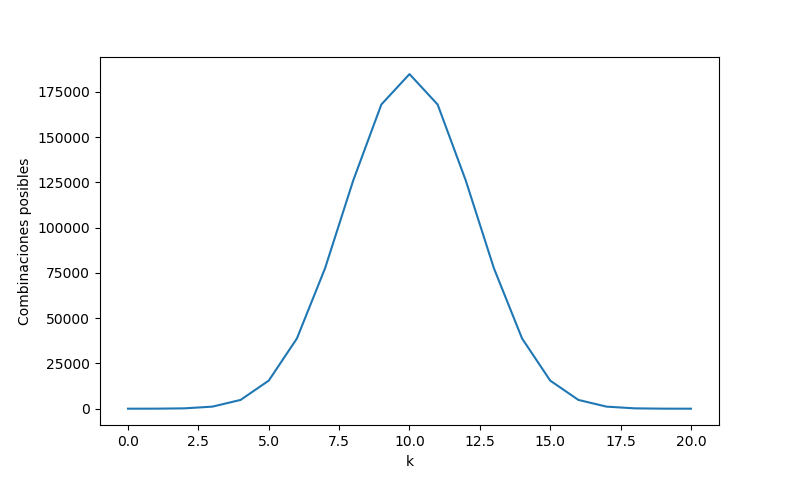

In [7]:
%matplotlib notebook
n = 20

comb_k = [combination_quantity(n, i) for i in range(n+1)]
plt.plot(comb_k)
plt.xlabel('k')
plt.ylabel('Combinaciones posibles')
plt.show()

In [41]:
print(combination_quantity(30, 7))

2035800.0
